In [1]:
import os
import json
import random
import argparse
import itertools
import math
import torch
import numpy as np
from torch import nn, optim
from torch.nn import functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.optim.lr_scheduler import StepLR
from torchvision import transforms
from tqdm import tqdm
from einops import rearrange
import matplotlib.pyplot as plt

import utils

from data_utils import (
    WBCdataset,
    pRCCdataset
)
from models import (
    ViT,
    MAE
)

WBC_mean = np.array([0.7049, 0.5392, 0.5885])
WBC_std = np.array([0.1626, 0.1902, 0.0974])

pRCC_mean = np.array([0.6843, 0.5012, 0.6436])
pRCC_std = np.array([0.2148, 0.2623, 0.1969])

def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    
def get_WBC_transform(is_train):
    data_transforms = []
    data_transforms.append(transforms.Resize((256, 256)))
    if is_train:
        data_transforms.append(transforms.RandomHorizontalFlip())
    data_transforms.append(transforms.ToTensor())
    data_transforms.append(transforms.Normalize(WBC_mean, WBC_std, inplace=True))
    return transforms.Compose(data_transforms)

def get_pRCC_transform():
    data_transforms = []
    data_transforms.append(transforms.CenterCrop(768))
    data_transforms.append(transforms.RandomCrop((256, 256)))
    # data_transforms.append(transforms.RandomHorizontalFlip())
    data_transforms.append(transforms.ToTensor())
    data_transforms.append(transforms.Normalize(pRCC_mean, pRCC_std, inplace=True))
    return transforms.Compose(data_transforms)

def run(device, hps):
    pRCC_data = pRCCdataset(hps.pRCCdata.training_files, transform=get_pRCC_transform())
    pRCC_data = torch.utils.data.Subset(pRCC_data, [0])
    train_data = WBCdataset(hps.WBCdata.training_files_1, hps.WBCdata.label_dict, transform=get_WBC_transform(True))
    valid_data = WBCdataset(hps.WBCdata.validation_files, hps.WBCdata.label_dict, transform=get_WBC_transform(False))
    
    vit = ViT(
        image_size = hps.WBCdata.image_size,
        patch_size = hps.WBCdata.patch_size,
        num_classes = hps.WBCdata.num_classes,
        **hps.ViTmodel
    ).to(device)
    
    mae = MAE(
        encoder = vit,
        **hps.MAEmodel
    ).to(device)
    
    pRCC_loader = DataLoader(dataset = pRCC_data, batch_size=hps.pretrain.batch_size, shuffle=True)
    
    # pretrain optimizer
    pt_optimizer = optim.Adam(mae.parameters(), lr=hps.pretrain.learning_rate)
    # pretrain scheduler
    pt_scheduler = StepLR(pt_optimizer, step_size=25, gamma=hps.pretrain.lr_decay)
    
    for epoch in tqdm(range(hps.pretrain.epochs)):
        pretrain(device, epoch, mae, pt_optimizer, pt_scheduler, pRCC_loader)
    
    train_loader = DataLoader(dataset = train_data, batch_size=hps.finetune.batch_size, shuffle=True)
    valid_loader = DataLoader(dataset = valid_data, batch_size=hps.finetune.batch_size, shuffle=True)
    
    # loss function
    criterion = nn.CrossEntropyLoss()
    # finetune optimizer
    ft_optimizer = optim.Adam(vit.parameters(), lr=hps.finetune.learning_rate)
    # finetune scheduler
    ft_scheduler = StepLR(ft_optimizer, step_size=1, gamma=hps.finetune.lr_decay)
    
    for epoch in range(hps.finetune.epochs):
        train_and_evaluate(device, epoch, vit, criterion, ft_optimizer, ft_scheduler, [train_loader, valid_loader])


        
def pretrain(device, epoch, model, optimizer, scheduler, loader):
    epoch_loss = 0
    
    for data, *_ in loader:
        optimizer.zero_grad()
        
        data = data.to(device)
        
        recon_loss, _ = model(data)
        
        recon_loss.backward()
        optimizer.step()
        scheduler.step()
        
        epoch_loss += recon_loss.item() / len(loader)
        
    if epoch%20 == 0:
        img = data.cpu()[0]
        model.eval()
        run_one_image(device, img, model, set_name='pRCC')
        model.train()
        
        print(
        f"Pretrain Epoch : {epoch+1} - Reconstruction loss : {epoch_loss:.4f}\n"
        )
        

@torch.no_grad()
def run_one_image(device, img, model, set_name='pRCC'):
    assert model.training is False
    
    if set_name=='pRCC':
        std = pRCC_std
        mean = pRCC_mean
    else:
        raise "NonImplemented."
        
    
    x = img
    img = rearrange(img, 'c h w -> h w c')
    plt.subplot(1, 2, 1)
    utils.show_image(img, std, mean, "input")
    
    x = x.unsqueeze(dim=0).to(device)
    loss, y = model(x)
    y = y.detach().cpu()[0]
    
    y = rearrange(y, 'c h w -> h w c')
    plt.subplot(1, 2, 2)
    utils.show_image(y, std, mean, "reconstructed")
    
    plt.show()
    

def train_and_evaluate(device, epoch, model, criterion, optimizer, scheduler, loaders):
    train_loader, valid_loader = loaders
    epoch_loss = 0
    epoch_accuracy = 0

    for data, label in tqdm(train_loader):
        optimizer.zero_grad()
        
        data = data.to(device)
        label = label.to(device)

        output = model(data)
        loss = criterion(output, label)
        
        loss.backward()
        optimizer.step()
        scheduler.step()

        acc = (output.argmax(dim=1) == label).float().mean()
        epoch_accuracy += acc / len(train_loader)
        epoch_loss += loss / len(train_loader)

    with torch.no_grad():
        model.eval()
        epoch_val_accuracy = 0
        epoch_val_loss = 0
        for data, label in valid_loader:
            data = data.to(device)
            label = label.to(device)

            val_output = model(data)
            val_loss = criterion(val_output, label)

            acc = (val_output.argmax(dim=1) == label).float().mean()
            epoch_val_accuracy += acc / len(valid_loader)
            epoch_val_loss += val_loss / len(valid_loader)
        model.train()

    print(
        f"Epoch : {epoch+1} - loss : {epoch_loss:.4f} - acc: {epoch_accuracy:.4f} - val_loss : {epoch_val_loss:.4f} - val_acc: {epoch_val_accuracy:.4f}\n"
    )

  0%|          | 0/5000 [00:00<?, ?it/s]

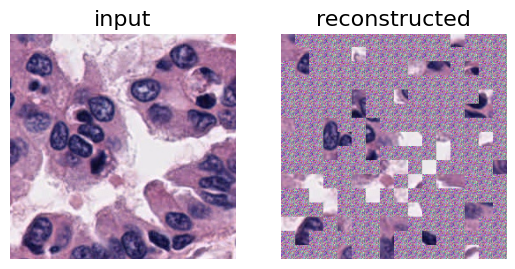

  0%|          | 1/5000 [00:00<1:13:37,  1.13it/s]

Pretrain Epoch : 1 - Reconstruction loss : 1.2752



  0%|          | 20/5000 [00:09<38:11,  2.17it/s] 

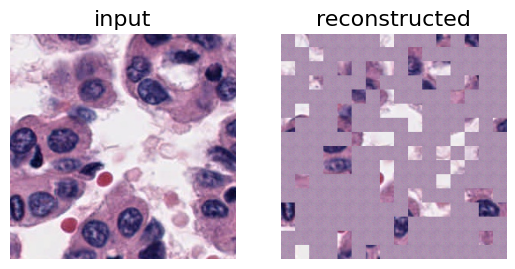

  0%|          | 21/5000 [00:10<43:17,  1.92it/s]

Pretrain Epoch : 21 - Reconstruction loss : 1.0767



  1%|          | 40/5000 [00:19<59:58,  1.38it/s]

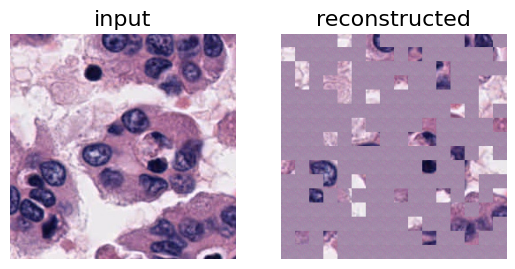

  1%|          | 41/5000 [00:19<59:36,  1.39it/s]

Pretrain Epoch : 41 - Reconstruction loss : 0.9923



  1%|          | 60/5000 [00:27<32:59,  2.50it/s]

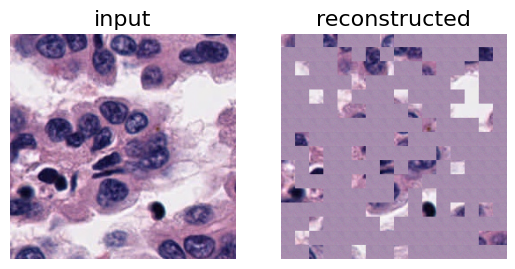

  1%|          | 61/5000 [00:28<40:24,  2.04it/s]

Pretrain Epoch : 61 - Reconstruction loss : 1.0547



  2%|▏         | 80/5000 [00:36<34:02,  2.41it/s]

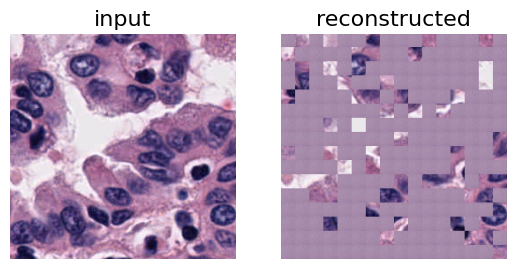

  2%|▏         | 81/5000 [00:37<40:42,  2.01it/s]

Pretrain Epoch : 81 - Reconstruction loss : 1.0471



  2%|▏         | 100/5000 [00:46<33:42,  2.42it/s]

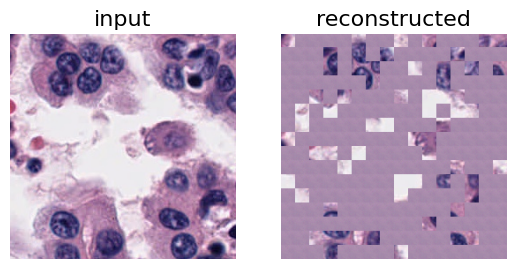

  2%|▏         | 101/5000 [00:47<39:50,  2.05it/s]

Pretrain Epoch : 101 - Reconstruction loss : 1.0537



  2%|▏         | 120/5000 [00:56<34:36,  2.35it/s]

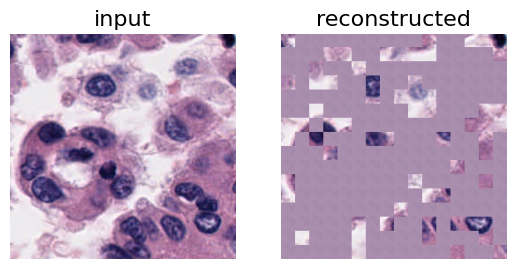

  2%|▏         | 121/5000 [00:56<41:26,  1.96it/s]

Pretrain Epoch : 121 - Reconstruction loss : 0.9561



  3%|▎         | 140/5000 [01:05<40:40,  1.99it/s]

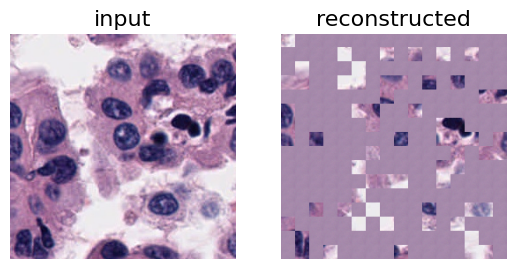

  3%|▎         | 141/5000 [01:06<44:42,  1.81it/s]

Pretrain Epoch : 141 - Reconstruction loss : 1.0272



  3%|▎         | 160/5000 [01:14<35:24,  2.28it/s]

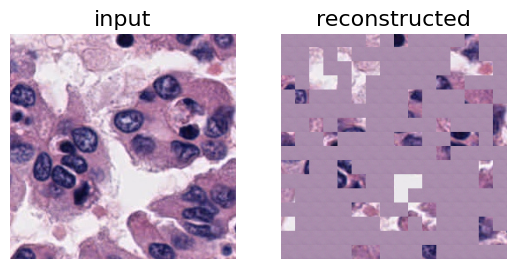

  3%|▎         | 161/5000 [01:16<1:06:25,  1.21it/s]

Pretrain Epoch : 161 - Reconstruction loss : 0.9372



  4%|▎         | 180/5000 [01:23<33:30,  2.40it/s]  

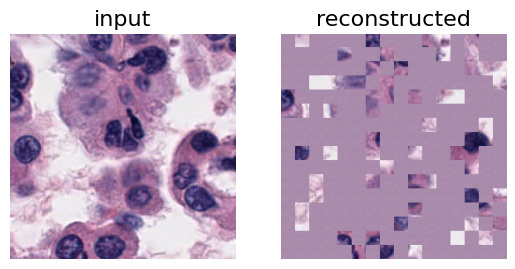

  4%|▎         | 181/5000 [01:24<40:05,  2.00it/s]

Pretrain Epoch : 181 - Reconstruction loss : 0.9624



  4%|▍         | 200/5000 [01:33<33:19,  2.40it/s]  

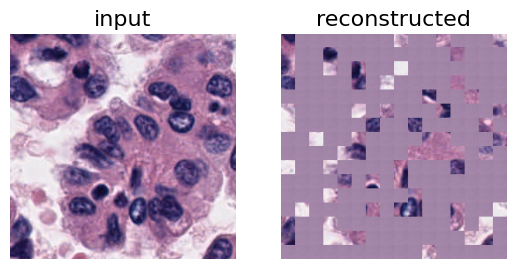

  4%|▍         | 201/5000 [01:34<39:43,  2.01it/s]

Pretrain Epoch : 201 - Reconstruction loss : 0.9519



  4%|▍         | 220/5000 [01:43<33:12,  2.40it/s]

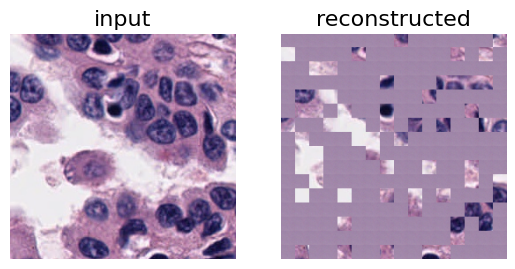

  4%|▍         | 221/5000 [01:44<42:59,  1.85it/s]

Pretrain Epoch : 221 - Reconstruction loss : 1.0318



  5%|▍         | 240/5000 [01:52<33:16,  2.38it/s]

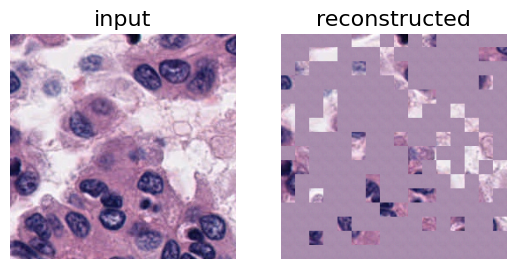

  5%|▍         | 241/5000 [01:53<38:48,  2.04it/s]

Pretrain Epoch : 241 - Reconstruction loss : 0.8266



  5%|▌         | 260/5000 [02:02<40:25,  1.95it/s]

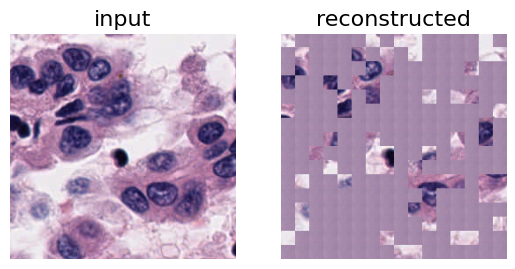

  5%|▌         | 261/5000 [02:02<44:51,  1.76it/s]

Pretrain Epoch : 261 - Reconstruction loss : 0.9910



  6%|▌         | 280/5000 [02:10<32:14,  2.44it/s]

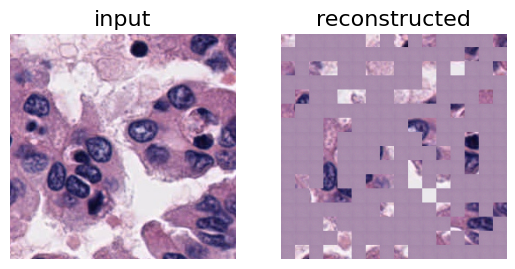

  6%|▌         | 281/5000 [02:12<1:06:24,  1.18it/s]

Pretrain Epoch : 281 - Reconstruction loss : 0.9386



  6%|▌         | 300/5000 [02:20<32:54,  2.38it/s]  

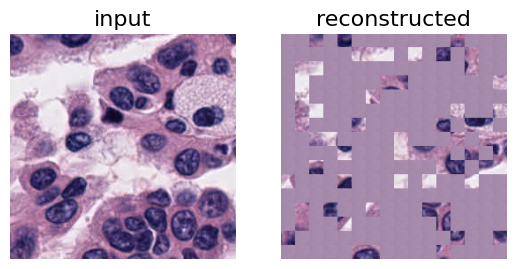

  6%|▌         | 301/5000 [02:21<39:56,  1.96it/s]

Pretrain Epoch : 301 - Reconstruction loss : 1.0171



  6%|▋         | 320/5000 [02:30<31:33,  2.47it/s]  

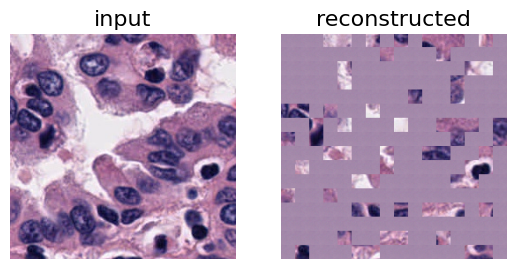

  6%|▋         | 321/5000 [02:30<37:37,  2.07it/s]

Pretrain Epoch : 321 - Reconstruction loss : 0.9788



  7%|▋         | 336/5000 [02:38<36:37,  2.12it/s]


KeyboardInterrupt: 

In [2]:
%matplotlib inline
hps = utils.get_hparams_from_file('./configs/base.json')
seed_everything(hps.seed)

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

run(device, hps)